# Transfer learning with transformer architecture

The purpose of this notebook is to show how finetuning improves the model's accuracy.  
Dataset used is Physionet MI. The dataset is split into three subdatasets:

- Dataset A (65 subjects)
- Dataset B (20 subjects)
- Dataset C (20 subjects)

Dataset A is used to pretrain the model before finetuning it with dataset B. Dataset C is used for testing.  
Comparison is done between two models for each architecture:

- one is trained on dataset B and tested with dataset C
- second is trained on dataset A, finetuned with dataset B and tested with dataset C

Five experimental runs are done for each transformer to calculate mean accuracy of both models.


In [1]:
import sys
import os
import warnings
import mne
import torch

warnings.filterwarnings("ignore")
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
mne.set_config("MNE_DATA", os.path.join(os.getcwd(), "data"))
mne.set_config("MNE_DATASETS_BNCI_PATH", os.path.join(os.getcwd(), "data"))
mne.set_config("MNE_DATASETS_EEGBCI_PATH", os.path.join(os.getcwd(), "data"))
mne.set_config("MNE_DATASETS_SHIN_PATH", os.path.join(os.getcwd(), "data"))
mne.set_config("MOABB_RESULTS", os.path.join(os.getcwd(), "results"))
os.makedirs(os.environ["MNE_DATA"], exist_ok=True)
os.makedirs(os.environ["MOABB_RESULTS"], exist_ok=True)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from importlib import reload
from mne.decoding import CSP, PSDEstimator
from sklearn.model_selection import KFold
from torchmetrics.classification import Accuracy
from statistics import mean, stdev

import scripts.transformer.transformer_models as trans
from scripts.dataset.eeg_dataset import EEGDataset
from scripts.features_extract.welch import extract_welch_features
from eeg_logger import logger

import moabb
from moabb.datasets import PhysionetMI
from moabb.paradigms import LeftRightImagery

moabb.set_log_level("info")

# Instantiate dataset and load data

MOABB makes working with datasets super easy. With Physionet we can specify which runs we want to analyze using `imagined` and `executed` flags. Setting `imagined` to **True** makes `get_data` method return runs 4, 8, 12, 6, 10, 14 because they contain imaginary tasks. For this work, we only need runs 4, 8, 12 because they contain left and right hand movement. The `get_data` method returns dict structured like this:  
`data[subject_index]["session_index"]["run_index"]`


In [2]:
dataset = PhysionetMI(imagined=True, executed=False)
subject_list = np.delete(np.arange(1, 110), [87, 91, 99, 103])
train_big_subjects = subject_list[:65]
train_small_subjects = subject_list[65:85]
test_subjects = subject_list[85:]
dataset.subject_list = subject_list

print(f"All subjects: {subject_list.shape}")
print(f"Big train datset: {train_big_subjects.shape}")
print(f"Small train dataset: {train_small_subjects.shape}")
print(f"Test datset: {test_subjects.shape}")

train_big_data = dataset.get_data(subjects=train_big_subjects.tolist())
train_small_data = dataset.get_data(subjects=train_small_subjects.tolist())
test_data = dataset.get_data(subjects=test_subjects.tolist())

All subjects: (105,)
Big train datset: (65,)
Small train dataset: (20,)
Test datset: (20,)


# Extract epochs related to motor imagery


In [3]:
def normalize(epochs: mne.Epochs) -> mne.epochs:
    """
    Applies z-score normalization according to this formula:
    X* = (X - mean) / std + aN
    """

    data: np.ndarray = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
    mean = data.mean(axis=2, keepdims=True)
    std = data.std(axis=2, keepdims=True)
    std[std == 0] = 1.0
    N = np.random.randn(*data.shape)
    a = 0.01

    zscored_data = (data - mean) / std + a * N
    epochs._data = zscored_data

    return epochs


selected_event_id = {"left_hand": 1, "right_hand": 3}  # BASED ON EVENT_IDS
tmin_3s, tmax_3s = 2.0, 5.0
channels = [
    "FC5",
    "FC3",
    "FC1",
    "FC2",
    "FC4",
    "FC6",
    "C5",
    "C3",
    "C1",
    "Cz",
    "C2",
    "C4",
    "C6",
    "CP5",
    "CP3",
    "CP1",
    "CP2",
    "CP4",
    "CP6",
]
epochs_big_dataset = []
epochs_small_dataset = []
epochs_test_dataset = []

for subject in subject_list:
    session_data = None

    if subject in train_big_subjects:
        session_data = train_big_data[subject]["0"]
    elif subject in train_small_subjects:
        session_data = train_small_data[subject]["0"]
    elif subject in test_subjects:
        session_data = test_data[subject]["0"]
    else:
        logger.error(f"Subject {subject} does not belong to any dataset")

    run_4 = session_data["0"]
    run_8 = session_data["1"]
    run_12 = session_data["2"]

    all_runs = mne.concatenate_raws([run_4, run_8, run_12])
    events, event_ids = mne.events_from_annotations(all_runs)
    if subject == 1:
        logger.info(f"Event ids: {event_ids}")

    epochs_3s = mne.Epochs(
        all_runs,
        events,
        event_id=selected_event_id,
        tmin=tmin_3s,
        tmax=tmax_3s,
        picks=channels,
        baseline=None,
        preload=True,
    )
    epochs_3s = normalize(epochs_3s)

    if subject in train_big_subjects:
        epochs_big_dataset.append(epochs_3s)
    elif subject in train_small_subjects:
        epochs_small_dataset.append(epochs_3s)
    elif subject in test_subjects:
        epochs_test_dataset.append(epochs_3s)
    else:
        logger.error(f"Subject {subject} does not belong to any dataset")

2025-08-28 12:29:27,857 - INFO - Event ids: {'left_hand': 1, 'rest': 2, 'right_hand': 3}


# Get data and labels from extracted epochs


In [4]:
def extract_data_from_epochs(epochs: mne.Epochs, label_mapping: dict | None = None) -> tuple[np.ndarray, np.ndarray]:
    X = epochs.get_data()
    y = epochs.events[:, -1]
    if label_mapping:
        y = np.array([label_mapping[label] for label in y])
    return X, y


X_big_train = []
y_big_train = []

X_small_train = []
y_small_train = []

X_test = []
y_test = []

for epochs in epochs_big_dataset:
    X, y = extract_data_from_epochs(epochs, label_mapping={1: 0, 3: 1})
    X_big_train.append(X)
    y_big_train.append(y)
for epochs in epochs_small_dataset:
    X, y = extract_data_from_epochs(epochs, label_mapping={1: 0, 3: 1})
    X_small_train.append(X)
    y_small_train.append(y)
for epochs in epochs_test_dataset:
    X, y = extract_data_from_epochs(epochs, label_mapping={1: 0, 3: 1})
    X_test.append(X)
    y_test.append(y)

X_big_train = np.concatenate(X_big_train)
y_big_train = np.concatenate(y_big_train)
X_small_train = np.concatenate(X_small_train)
y_small_train = np.concatenate(y_small_train)
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

# Train and evaluate methods

Here methods for testing and evaluating models are defined. The purpose of this work is to show how finetuning improves accuracy. Five different transformer models are tested.


In [ ]:
from enum import Enum


LR = 7e-4
WEIGHT_DECAY = 1e-4
EPOCHS = 50
FINETUNE_LR = 1e-5
FINETUNE_WEIGHT_DECAY = 0
FINETUNE_EPOCHS = 7


class ModelType(Enum):
    SPATIAL = 1
    TEMPORAL = 2
    SPATIAL_CNN = 3
    TEMPORAL_CNN = 4
    FUSION_CNN = 5


def __is_cnn(model_type: ModelType) -> bool:
    return model_type in [ModelType.SPATIAL_CNN, ModelType.TEMPORAL_CNN, ModelType.FUSION_CNN]


def build_model(model_type: ModelType, X_train: np.ndarray) -> torch.nn.Module:
    model = None
    match (model_type):
        case ModelType.SPATIAL:
            model = trans.SpatialTransformer(input_size=X_train.shape[2], d_model=64, num_heads=8, num_classes=2)
        case ModelType.TEMPORAL:
            model = trans.TemporalTransformer(input_size=X_train.shape[1], d_model=64, num_heads=8, num_classes=2)
        case ModelType.SPATIAL_CNN:
            model = trans.SpatialCNNTransformer(d_model=64, num_heads=8, num_classes=2)
        case ModelType.TEMPORAL_CNN:
            model = trans.TemporalCNNTransformer(d_model=64, num_heads=8, num_classes=2)
        case ModelType.FUSION_CNN:
            model = trans.FusionCNNTransformer(d_model=64, num_heads=8, num_classes=2)
        case _:
            logger.error("Wrong model type!")
            return
    return model


def __train_model(
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    epochs: int = EPOCHS,
    verbose: bool = False,
) -> torch.nn.Module:
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    train_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * X_batch.size(0)
        train_losses.append(total_loss / len(train_loader.dataset))
        if verbose:
            logger.info(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

    return train_losses


def train_and_evaluate_model(
    model_type: ModelType,
    device: torch.device,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    X_finetune: np.ndarray = None,
    y_finetune: np.ndarray = None,
):
    cnn_mode = __is_cnn(model_type)
    train_loader = torch.utils.data.DataLoader(
        EEGDataset(X_train, y_train, cnn_mode=cnn_mode),
        batch_size=32,
        shuffle=True,
    )
    test_loader = torch.utils.data.DataLoader(
        EEGDataset(X_test, y_test, cnn_mode=cnn_mode), batch_size=32, shuffle=False
    )

    model = build_model(model_type, X_train)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    train_losses = __train_model(model, train_loader, optimizer, device, epochs=50)

    if X_finetune is not None and y_finetune is not None:
        train_loader_ft = torch.utils.data.DataLoader(
            EEGDataset(X_finetune, y_finetune, cnn_mode=cnn_mode), batch_size=32, shuffle=True
        )
        finetune_optimizer = torch.optim.Adam(model.parameters(), lr=FINETUNE_LR, weight_decay=FINETUNE_WEIGHT_DECAY)
        __train_model(model, train_loader_ft, finetune_optimizer, device, epochs=FINETUNE_EPOCHS)

    accuracy = evaluate_model(model, device, test_loader)

    return model, accuracy, train_losses


def evaluate_model(model: torch.nn.Module, device: torch.device, test_loader: torch.utils.data.DataLoader) -> float:
    """
    Computes accuracy of provided model.
    """
    acc = Accuracy(task="binary").to(device)
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            preds = torch.argmax(output, dim=1)
            acc.update(preds, y_batch)

    return acc.compute().item()


def plot_training_loss(loss: np.ndarray):
    plt.figure(figsize=(9, 5))
    plt.plot(np.arange(1, EPOCHS + 1), loss, label="Training loss", color="blue")
    # plt.axvline(x=EPOCHS, color="red", linestyle="--", label="Start Finetuning")
    plt.title("Training loss over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


runs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cpu":
    logger.warning("Warning - training will be done on cpu")
else:
    logger.info("Training will be done on gpu")

2025-08-28 14:01:16,176 - INFO - Training will be done on gpu


# Training and evaluating Spatial transformer


2025-08-28 14:01:19,630 - INFO - Run 1/5
2025-08-28 14:01:27,569 - INFO - Accuracy for SpatialTransformer without finetuning: 54.64%
2025-08-28 14:01:51,454 - INFO - Accuracy for SpatialTransformer with finetuning: 62.38%
2025-08-28 14:01:51,455 - INFO - Run 2/5
2025-08-28 14:01:59,113 - INFO - Accuracy for SpatialTransformer without finetuning: 56.31%
2025-08-28 14:02:23,348 - INFO - Accuracy for SpatialTransformer with finetuning: 64.40%
2025-08-28 14:02:23,349 - INFO - Mean accuracy over 5 runs without finetuning: 55.48% +- 1.18%
2025-08-28 14:02:23,349 - INFO - Mean accuracy over 5 runs with finetuning: 63.39% +- 1.43%


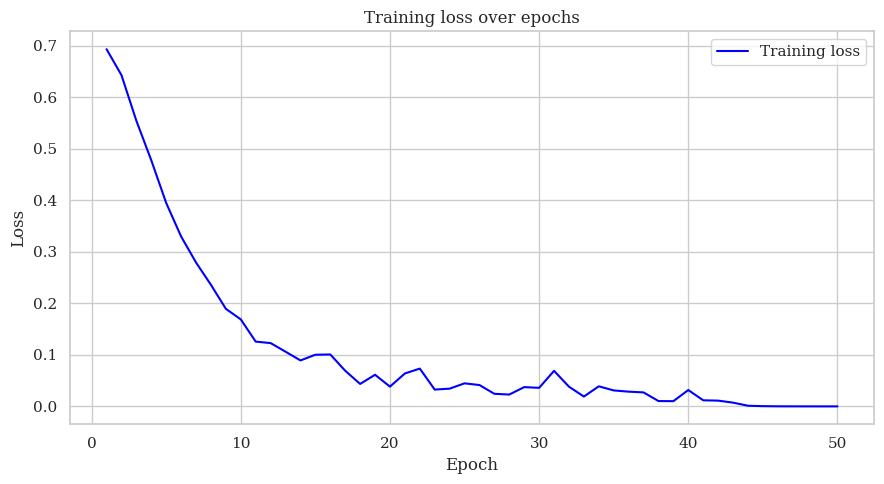

In [78]:
accuracies_no_finetune = []
accuracies_finetune = []
all_losses = []
model_type = ModelType.SPATIAL

for run in range(2):

    logger.info(f"Run {run+1}/{runs}")

    model, accuracy, _ = train_and_evaluate_model(model_type, device, X_small_train, y_small_train, X_test, y_test)

    logger.info(f"Accuracy for {model._get_name()} without finetuning: {accuracy * 100:.2f}%")
    accuracies_no_finetune.append(accuracy)

    model, accuracy, train_losses = train_and_evaluate_model(
        model_type, device, X_big_train, y_big_train, X_test, y_test, X_small_train, y_small_train
    )
    all_losses.append(train_losses)

    logger.info(f"Accuracy for {model._get_name()} with finetuning: {accuracy * 100:.2f}%")
    accuracies_finetune.append(accuracy)

acc_mean_no_finetune = mean(accuracies_no_finetune)
std_no_finetune = stdev(accuracies_no_finetune)
acc_mean_finetune = mean(accuracies_finetune)
std_finetune = stdev(accuracies_finetune)

logger.info(
    f"Mean accuracy over {runs} runs without finetuning: {acc_mean_no_finetune * 100:.2f}% +- {std_no_finetune * 100:.2f}%"
)
logger.info(
    f"Mean accuracy over {runs} runs with finetuning: {acc_mean_finetune * 100:.2f}% +- {std_finetune * 100:.2f}%"
)

mean_loss = np.mean(np.array(all_losses), axis=0)
plot_training_loss(mean_loss)

# Training and evaluating Temporal Transformer


In [ ]:
accuracies_no_finetune = []
accuracies_finetune = []
model_type = ModelType.TEMPORAL

for run in range(runs):

    logger.info(f"Run {run+1}/{runs}")

    model, cnn_mode = train_and_evaluate_model(model_type, device, X_small_train, y_small_train)
    accuracy = evaluate_model(model, device, cnn_mode, X_test, y_test)

    logger.info(f"Accuracy for {model._get_name()} without finetuning: {accuracy * 100:.2f}%")
    accuracies_no_finetune.append(accuracy)

    model, cnn_mode = train_and_evaluate_model(
        model_type, device, X_big_train, y_big_train, X_small_train, y_small_train
    )
    accuracy = evaluate_model(model, device, cnn_mode, X_test, y_test)

    logger.info(f"Accuracy for {model._get_name()} with finetuning: {accuracy * 100:.2f}%")
    accuracies_finetune.append(accuracy)

acc_mean_no_finetune = mean(accuracies_no_finetune)
std_no_finetune = stdev(accuracies_no_finetune)
acc_mean_finetune = mean(accuracies_finetune)
std_finetune = stdev(accuracies_finetune)

logger.info(
    f"Mean accuracy over {runs} runs without finetuning: {acc_mean_no_finetune * 100:.2f}% +- {std_no_finetune * 100:.2f}%"
)
logger.info(
    f"Mean accuracy over {runs} runs with finetuning: {acc_mean_finetune * 100:.2f}% +- {std_finetune * 100:.2f}%"
)

2025-08-25 16:07:06,216 - INFO - Run 1/5
2025-08-25 16:08:47,212 - INFO - Accuracy for TemporalTransformer without finetuning: 66.43%
2025-08-25 16:14:21,582 - INFO - Accuracy for TemporalTransformer with finetuning: 68.45%
2025-08-25 16:14:21,583 - INFO - Run 2/5
2025-08-25 16:16:01,918 - INFO - Accuracy for TemporalTransformer without finetuning: 63.93%
2025-08-25 16:21:36,950 - INFO - Accuracy for TemporalTransformer with finetuning: 65.71%
2025-08-25 16:21:36,952 - INFO - Run 3/5
2025-08-25 16:23:17,467 - INFO - Accuracy for TemporalTransformer without finetuning: 64.88%
2025-08-25 16:28:52,834 - INFO - Accuracy for TemporalTransformer with finetuning: 66.67%
2025-08-25 16:28:52,838 - INFO - Run 4/5
2025-08-25 16:30:33,416 - INFO - Accuracy for TemporalTransformer without finetuning: 64.52%
2025-08-25 16:36:08,744 - INFO - Accuracy for TemporalTransformer with finetuning: 67.02%
2025-08-25 16:36:08,746 - INFO - Run 5/5
2025-08-25 16:37:49,259 - INFO - Accuracy for TemporalTransform

# Training and evaluating SpatialCNN transformer


In [ ]:
accuracies_no_finetune = []
accuracies_finetune = []
model_type = ModelType.SPATIAL_CNN

for run in range(runs):

    logger.info(f"Run {run+1}/{runs}")

    model, cnn_mode = train_and_evaluate_model(model_type, device, X_small_train, y_small_train)
    accuracy = evaluate_model(model, device, cnn_mode, X_test, y_test)

    logger.info(f"Accuracy for {model._get_name()} without finetuning: {accuracy * 100:.2f}%")
    accuracies_no_finetune.append(accuracy)

    model, cnn_mode = train_and_evaluate_model(
        model_type, device, X_big_train, y_big_train, X_small_train, y_small_train
    )
    accuracy = evaluate_model(model, device, cnn_mode, X_test, y_test)

    logger.info(f"Accuracy for {model._get_name()} with finetuning: {accuracy * 100:.2f}%")
    accuracies_finetune.append(accuracy)

acc_mean_no_finetune = mean(accuracies_no_finetune)
std_no_finetune = stdev(accuracies_no_finetune)
acc_mean_finetune = mean(accuracies_finetune)
std_finetune = stdev(accuracies_finetune)

logger.info(
    f"Mean accuracy over {runs} runs without finetuning: {acc_mean_no_finetune * 100:.2f}% +- {std_no_finetune * 100:.2f}%"
)
logger.info(
    f"Mean accuracy over {runs} runs with finetuning: {acc_mean_finetune * 100:.2f}% +- {std_finetune * 100:.2f}%"
)

2025-08-25 16:00:16,290 - INFO - Run 1/5
2025-08-25 16:00:32,900 - INFO - Accuracy for SpatialCNNTransformer without finetuning: 61.79%
2025-08-25 16:01:27,665 - INFO - Accuracy for SpatialCNNTransformer with finetuning: 66.43%
2025-08-25 16:01:27,666 - INFO - Run 2/5
2025-08-25 16:01:44,458 - INFO - Accuracy for SpatialCNNTransformer without finetuning: 62.26%
2025-08-25 16:02:38,248 - INFO - Accuracy for SpatialCNNTransformer with finetuning: 66.19%
2025-08-25 16:02:38,250 - INFO - Run 3/5
2025-08-25 16:02:54,325 - INFO - Accuracy for SpatialCNNTransformer without finetuning: 61.79%
2025-08-25 16:03:48,036 - INFO - Accuracy for SpatialCNNTransformer with finetuning: 68.10%
2025-08-25 16:03:48,038 - INFO - Run 4/5
2025-08-25 16:04:04,561 - INFO - Accuracy for SpatialCNNTransformer without finetuning: 62.62%
2025-08-25 16:04:58,553 - INFO - Accuracy for SpatialCNNTransformer with finetuning: 65.71%
2025-08-25 16:04:58,555 - INFO - Run 5/5
2025-08-25 16:05:14,708 - INFO - Accuracy for S

# Training and evaluating TemporalCNN transformer


In [ ]:
accuracies_no_finetune = []
accuracies_finetune = []
model_type = ModelType.TEMPORAL_CNN

for run in range(runs):

    logger.info(f"Run {run+1}/{runs}")

    model, cnn_mode = train_and_evaluate_model(model_type, device, X_small_train, y_small_train)
    accuracy = evaluate_model(model, device, cnn_mode, X_test, y_test)

    logger.info(f"Accuracy for {model._get_name()} without finetuning: {accuracy * 100:.2f}%")
    accuracies_no_finetune.append(accuracy)

    model, cnn_mode = train_and_evaluate_model(
        model_type, device, X_big_train, y_big_train, X_small_train, y_small_train
    )
    accuracy = evaluate_model(model, device, cnn_mode, X_test, y_test)

    logger.info(f"Accuracy for {model._get_name()} with finetuning: {accuracy * 100:.2f}%")
    accuracies_finetune.append(accuracy)

acc_mean_no_finetune = mean(accuracies_no_finetune)
std_no_finetune = stdev(accuracies_no_finetune)
acc_mean_finetune = mean(accuracies_finetune)
std_finetune = stdev(accuracies_finetune)

logger.info(
    f"Mean accuracy over {runs} runs without finetuning: {acc_mean_no_finetune * 100:.2f}% +- {std_no_finetune * 100:.2f}%"
)
logger.info(
    f"Mean accuracy over {runs} runs with finetuning: {acc_mean_finetune * 100:.2f}% +- {std_finetune * 100:.2f}%"
)

2025-08-25 15:41:19,681 - INFO - Run 1/5
2025-08-25 15:41:36,726 - INFO - Accuracy for TemporalCNNTransformer without finetuning: 57.14%
2025-08-25 15:42:33,519 - INFO - Accuracy for TemporalCNNTransformer with finetuning: 64.29%
2025-08-25 15:42:33,523 - INFO - Run 2/5
2025-08-25 15:42:50,481 - INFO - Accuracy for TemporalCNNTransformer without finetuning: 61.67%
2025-08-25 15:43:46,581 - INFO - Accuracy for TemporalCNNTransformer with finetuning: 64.88%
2025-08-25 15:43:46,582 - INFO - Run 3/5
2025-08-25 15:44:03,827 - INFO - Accuracy for TemporalCNNTransformer without finetuning: 55.95%
2025-08-25 15:45:00,180 - INFO - Accuracy for TemporalCNNTransformer with finetuning: 66.79%
2025-08-25 15:45:00,182 - INFO - Run 4/5
2025-08-25 15:45:17,095 - INFO - Accuracy for TemporalCNNTransformer without finetuning: 59.52%
2025-08-25 15:46:13,758 - INFO - Accuracy for TemporalCNNTransformer with finetuning: 64.76%
2025-08-25 15:46:13,761 - INFO - Run 5/5
2025-08-25 15:46:30,709 - INFO - Accura

# Training and evaluating FusionCNN transformer


In [ ]:
accuracies_no_finetune = []
accuracies_finetune = []
model_type = ModelType.FUSION_CNN

for run in range(runs):

    logger.info(f"Run {run+1}/{runs}")

    model, cnn_mode = train_and_evaluate_model(model_type, device, X_small_train, y_small_train)
    accuracy = evaluate_model(model, device, cnn_mode, X_test, y_test)

    logger.info(f"Accuracy for {model._get_name()} without finetuning: {accuracy * 100:.2f}%")
    accuracies_no_finetune.append(accuracy)

    model, cnn_mode = train_and_evaluate_model(
        model_type, device, X_big_train, y_big_train, X_small_train, y_small_train
    )
    accuracy = evaluate_model(model, device, cnn_mode, X_test, y_test)

    logger.info(f"Accuracy for {model._get_name()} with finetuning: {accuracy * 100:.2f}%")
    accuracies_finetune.append(accuracy)

acc_mean_no_finetune = mean(accuracies_no_finetune)
std_no_finetune = stdev(accuracies_no_finetune)
acc_mean_finetune = mean(accuracies_finetune)
std_finetune = stdev(accuracies_finetune)

logger.info(
    f"Mean accuracy over {runs} runs without finetuning: {acc_mean_no_finetune * 100:.2f}% +- {std_no_finetune * 100:.2f}%"
)
logger.info(
    f"Mean accuracy over {runs} runs with finetuning: {acc_mean_finetune * 100:.2f}% +- {std_finetune * 100:.2f}%"
)

2025-08-25 15:47:37,710 - INFO - Run 1/5
2025-08-25 15:48:06,606 - INFO - Accuracy for FusionCNNTransformer without finetuning: 61.31%
2025-08-25 15:49:41,873 - INFO - Accuracy for FusionCNNTransformer with finetuning: 64.52%
2025-08-25 15:49:41,874 - INFO - Run 2/5
2025-08-25 15:50:10,574 - INFO - Accuracy for FusionCNNTransformer without finetuning: 61.90%
2025-08-25 15:51:45,258 - INFO - Accuracy for FusionCNNTransformer with finetuning: 66.07%
2025-08-25 15:51:45,260 - INFO - Run 3/5
2025-08-25 15:52:14,348 - INFO - Accuracy for FusionCNNTransformer without finetuning: 61.19%
2025-08-25 15:53:48,967 - INFO - Accuracy for FusionCNNTransformer with finetuning: 67.38%
2025-08-25 15:53:48,969 - INFO - Run 4/5
2025-08-25 15:54:17,733 - INFO - Accuracy for FusionCNNTransformer without finetuning: 60.95%
2025-08-25 15:55:52,736 - INFO - Accuracy for FusionCNNTransformer with finetuning: 65.95%
2025-08-25 15:55:52,739 - INFO - Run 5/5
2025-08-25 15:56:21,838 - INFO - Accuracy for FusionCNN

# Create plot with results


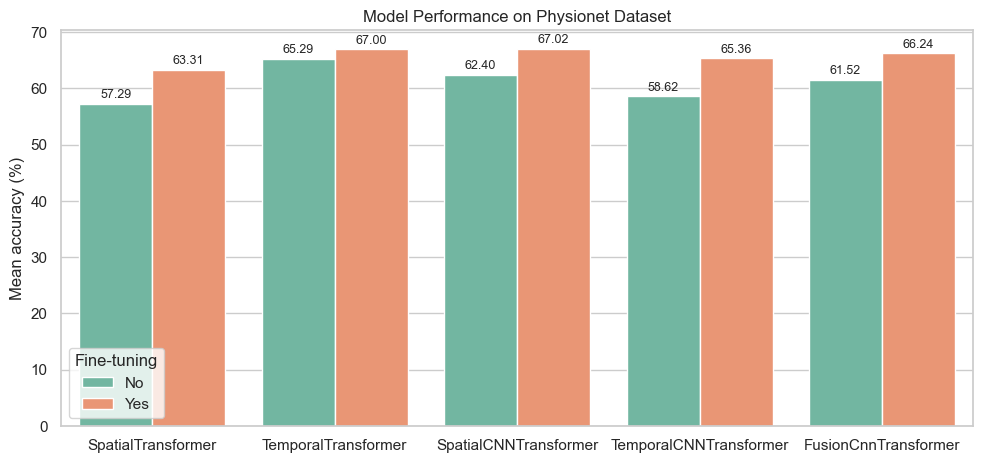

In [16]:
plot_data = {
    "Model": [
        "SpatialTransformer",
        "SpatialTransformer",
        "TemporalTransformer",
        "TemporalTransformer",
        "SpatialCNNTransformer",
        "SpatialCNNTransformer",
        "TemporalCNNTransformer",
        "TemporalCNNTransformer",
        "FusionCnnTransformer",
        "FusionCnnTransformer",
    ],
    "Finetuning": ["No", "Yes"] * 5,
    "Mean accuracy (%)": [57.29, 63.31, 65.29, 67.00, 62.40, 67.02, 58.62, 65.36, 61.52, 66.24],
}

# Create DataFrame
df = pd.DataFrame(plot_data)

# Set plot style
sns.set(style="whitegrid")

# Create bar plot
plt.figure(figsize=(10, 5))
barplot = sns.barplot(data=df, x="Model", y="Mean accuracy (%)", hue="Finetuning", palette="Set2")

# Annotate bars with values
for container in barplot.containers:
    barplot.bar_label(container, fmt="%.2f", label_type="edge", fontsize=9, padding=2)

# Improve layout
plt.title("Model Performance on Physionet Dataset")
plt.tight_layout()
plt.xlabel("")
plt.legend(title="Fine-tuning")

# Show plot
plt.show()